In [1]:
import json

from pathlib import Path
from pylab import cm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from layout_gnn.dataset.dataset import RICOSemanticAnnotationsDataset
from layout_gnn.dataset.transformations import *
from layout_gnn.utils import *
from layout_gnn.similarity_metrics import compute_edit_distance, compute_iou
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

ROOT_PATH = Path.cwd()
DATA_PATH = ROOT_PATH / '../data'
DATA_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
rico_dataset = RICOSemanticAnnotationsDataset(
    transform=transforms.Compose([
        process_data,
        normalize_bboxes,
        add_networkx,
    ]),
    only_data=True
)

In [3]:
dataloader = DataLoader(rico_dataset, batch_size=1, num_workers=16, collate_fn=default_data_collate)
dataset = []

for data in tqdm(dataloader):
    dataset.extend(data)
    
dataset = sorted(dataset, key=lambda x: x['filename'])

  0%|          | 0/65536 [00:00<?, ?it/s]

In [4]:
datapoint_1, datapoint_2 = dataset[100], dataset[5]

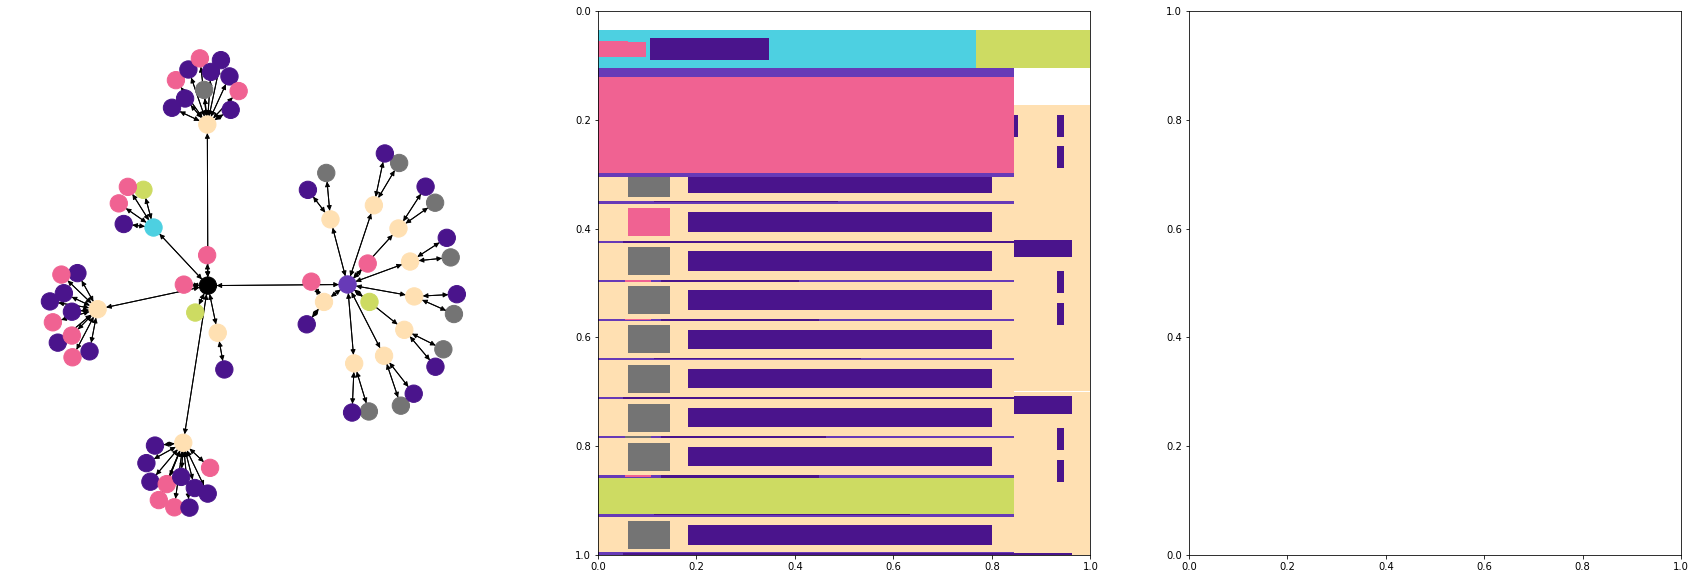

In [5]:
fig = plot_datapoint(datapoint_1, rico_dataset.label_color_map)

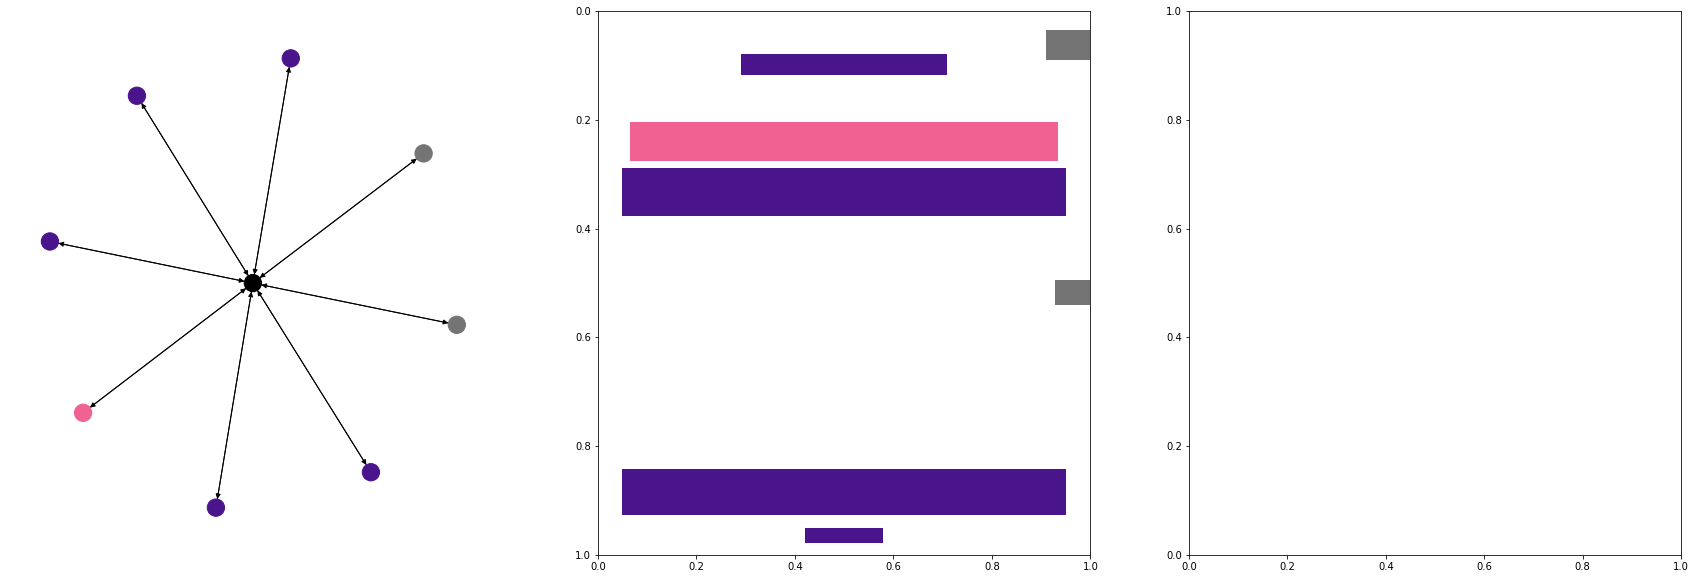

In [6]:
fig = plot_datapoint(datapoint_2, rico_dataset.label_color_map)

## Compute ED between both trees

In [7]:
compute_edit_distance(datapoint_1['graph'].to_undirected(), datapoint_2['graph'].to_undirected())

{'edit_distance': 67.0, 'normalized_edit_distance': 0.788235294117647}

In [8]:
node_labels = sorted(list(set(node['label'] for _, node in datapoint_1['graph'].nodes(data=True)) | set(node['label'] for _, node in datapoint_2['graph'].nodes(data=True))))
node_labels = {label: idx for idx, label in enumerate(node_labels)}
image_shape = (256, 256)

In [9]:
compute_iou(datapoint_1, datapoint_2)

0.3227272326194951

In [12]:
def compute_iou_distances(datapoint1,datapoint2):
    iou = compute_iou(datapoint1, datapoint2)
    ted = compute_edit_distance(datapoint1['graph'].to_undirected(), datapoint2['graph'].to_undirected())
    return [{
        'graph1': datapoint1['filename'],
        'graph2': datapoint2['filename'],
        'iou': iou,
        **ted
    }]

In [14]:
n = len(dataset)
total_size = n * (n+1) / 2 

In [15]:
iou_similarities = Parallel(n_jobs=4)(delayed(compute_iou_distances)(datapoint1,datapoint2) for i, datapoint1 in tqdm(enumerate(dataset), total=len(dataset)) for datapoint2 in dataset[i+1:] )

  0%|          | 0/65536 [00:00<?, ?it/s]

/media/disk/workspace/Layout-GNN/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error: Canceled future for execute_request message before replies were done